# Project: Chocolate Bar Rating Classification - Khoirotun Hisan

Klasifikasi rating cokelat bar berdasarkan atribut produk menggunakan machine learning.


## 1. Domain Proyek
Cokelat adalah salah satu makanan paling populer di dunia, dan kualitasnya sangat bervariasi tergantung pada berbagai faktor seperti persentase kakao, asal biji kakao, dan teknik pembuatan. Dalam proyek ini, kita akan mencoba mengklasifikasikan rating dari sebuah cokelat bar berdasarkan fitur-fitur tersebut.

## 2. Business Understanding
**Problem Statement:**
Dapatkah kita memprediksi kategori rating cokelat berdasarkan fitur-fitur seperti kakao, negara asal, dan perusahaan pembuat?

**Goal:**
Mengklasifikasikan rating cokelat ke dalam kategori seperti `low`, `medium`, dan `high`.

**Solution Statement:**
- Menggunakan Random Forest Classifier sebagai baseline model.
- Melakukan hyperparameter tuning untuk meningkatkan performa model.
- Menggunakan evaluasi berdasarkan classification report dan confusion matrix untuk menilai performa model.

## 3. Data Understanding
Dataset diambil dari Kaggle: [Chocolate Bar Ratings](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings)

- Jumlah data: ~1700 baris
- Target: Kolom `Rating`
- Fitur penting: `Cocoa Percent`, `Company Location`, `Country of Bean Origin`
- Akan dikategorikan menjadi `low`, `medium`, dan `high` untuk klasifikasi.

Selanjutnya akan dilakukan analisis eksploratif.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Selanjutnya, kita load dataset dan mulai eksplorasi datanya.

  Company \n(Maker-if known) Specific Bean Origin\nor Bar Name   REF  \
0                   A. Morin                       Agua Grande  1876   
1                   A. Morin                             Kpime  1676   
2                   A. Morin                            Atsane  1676   
3                   A. Morin                             Akata  1680   
4                   A. Morin                            Quilla  1704   

   Review\nDate Cocoa\nPercent Company\nLocation  Rating Bean\nType  \
0          2016            63%            France    3.75              
1          2015            70%            France    2.75              
2          2015            70%            France    3.00              
3          2015            70%            France    3.50              
4          2015            70%            France    3.50              

  Broad Bean\nOrigin  
0           Sao Tome  
1               Togo  
2               Togo  
3               Togo  
4               Peru  
<c

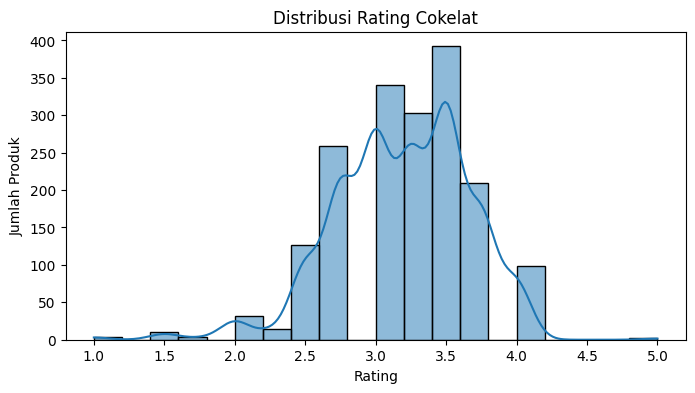

In [32]:
df = pd.read_csv('flavors_of_cacao.csv')
print(df.head())
print(df.info())
print(df.isnull().sum())

plt.figure(figsize=(8, 4))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribusi Rating Cokelat')
plt.xlabel('Rating')
plt.ylabel('Jumlah Produk')
plt.show()

## 4. Data Preparation
### Teknik yang Dilakukan:
- Menghapus kolom tidak relevan: `Company (Maker-if known)` dan `Specific Bean Origin (or Name)`
- Membersihkan dan menstandarkan nama kolom
- Mengubah `Cocoa Percent` dari string ke numerik
- Membuat label klasifikasi baru dari `Rating` menggunakan binning
- Melakukan label encoding pada fitur kategorikal: `Company Location` dan `Broad Bean Origin`
- Split data menjadi data latih dan data uji (80:20)

In [33]:
# 1. Hapus kolom tidak relevan
df.columns = df.columns.str.strip()
df.drop(columns=['Company\xa0\n(Maker-if known)', 'Specific Bean Origin\nor Bar Name'], inplace=True, errors='ignore')
print(df.columns)

Index(['REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')


In [39]:
# 2. Standarkan nama kolom
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\n', '_')

# 3. Ubah cocoa_percent menjadi numerik
if 'cocoa_percent' in df.columns:
    print(f"Data type of 'cocoa_percent' before conversion: {df['cocoa_percent'].dtype}")
    if df['cocoa_percent'].dtype == 'object':
        df['cocoa_percent'] = df['cocoa_percent'].str.replace('%', '', regex=False).astype(float)
    else:
        try:
            df['cocoa_percent'] = df['cocoa_percent'].astype(float)
        except ValueError as e:
            print(f"Could not convert 'cocoa_percent' to float. Error: {e}")
else:
    print("'cocoa_percent' column not found.")

# 4. Buat label klasifikasi dari rating
def label_rating(rating):
    if rating < 3.0:
        return 'low'
    elif rating < 3.5:
        return 'medium'
    else:
        return 'high'

if 'rating' in df.columns:
    df['rating_label'] = df['rating'].apply(label_rating)
else:
    print("'rating' column not found for creating 'rating_label'.")

# 5. Label encoding pada fitur kategorikal
if 'company_location' in df.columns:
    label_enc_location = LabelEncoder()
    df['company_location'] = label_enc_location.fit_transform(df['company_location'])
else:
     print("'company_location' column not found for label encoding.")

if 'broad_bean_origin' in df.columns:
    label_enc_origin = LabelEncoder()
    df['broad_bean_origin'] = label_enc_origin.fit_transform(df['broad_bean_origin'])
else:
    print("'broad_bean_origin' column not found for label encoding.")

print("\nData types before splitting:")
print(df.dtypes)

numeric_cols = ['ref', 'review_date', 'cocoa_percent', 'company_location', 'broad_bean_origin']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().any():
            print(f"\nFound non-numeric values (now NaN) in '{col}':")
            display(df[df[col].isnull()])
    else:
        print(f"Column '{col}' not found in DataFrame.")

    label_enc_3 = LabelEncoder()
    df['bean_type'] = df['bean_type'].fillna('Unknown')
    df['bean_type'] = label_enc_3.fit_transform(df['bean_type'])

Data type of 'cocoa_percent' before conversion: float64

Data types before splitting:
ref                    int64
review_date            int64
cocoa_percent        float64
company_location       int64
rating               float64
bean_type              int64
broad_bean_origin      int64
rating_label          object
dtype: object


## 5. Modeling

### Algoritma yang Digunakan:
- Random Forest Classifier

### Penjelasan Tahapan dan Parameter:
- Model dilatih menggunakan `RandomForestClassifier` dari `scikit-learn` dengan parameter default.
- Algoritma ini menggunakan banyak pohon keputusan (decision trees) dan menggabungkan hasilnya secara voting untuk klasifikasi.
- Data dibagi ke dalam 80% pelatihan dan 20% pengujian.

In [40]:
# 6. Pisahkan fitur dan target
features_to_drop = ['rating', 'rating_label']
cols_present = [col for col in features_to_drop if col in df.columns]
X = df.drop(columns=cols_present, errors='ignore')

if 'rating_label' in df.columns:
    y = df['rating_label']
else:
    print("'rating_label' column not found. Cannot proceed with splitting and modeling.")

# 7. Split data
if 'y' in locals() and not y.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nShape of X_train:", X_train.shape)
    print("Data types of X_train:\n", X_train.dtypes)

    if X_train.isnull().values.any():
        print("\nNaN values found in X_train. Please handle them before fitting the model.")
    else:
        rf_clf = RandomForestClassifier(random_state=42)
        rf_clf.fit(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        grid_search = GridSearchCV(
            RandomForestClassifier(random_state=42),
            param_grid,
            cv=3,
            scoring='accuracy',
            n_jobs=-1
        )

        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)

        # Model terbaik
        best_model = grid_search.best_estimator_

        print("\nModel training completed successfully!")
else:
    print("Could not proceed with splitting and modeling as 'y' is not defined or empty.")


Shape of X_train: (1436, 6)
Data types of X_train:
 ref                    int64
review_date            int64
cocoa_percent        float64
company_location       int64
bean_type              int64
broad_bean_origin      int64
dtype: object

Model training completed successfully!


## 6. Evaluasi

### Metrik Evaluasi yang Digunakan:
- Confusion Matrix
- Classification Report (Akurasi, Precision, Recall, F1-Score)

### Penjelasan Hasil Evaluasi:
- Hasil klasifikasi menunjukkan bagaimana model mampu memprediksi kelas low, medium, dan high dengan tingkat akurasi tertentu.
- Dari confusion matrix dapat dilihat berapa banyak prediksi yang benar dan salah untuk tiap kelas.

Classification Report:

              precision    recall  f1-score   support

        high       0.49      0.56      0.53       140
         low       0.45      0.28      0.34        90
      medium       0.41      0.46      0.43       129

    accuracy                           0.45       359
   macro avg       0.45      0.43      0.43       359
weighted avg       0.45      0.45      0.45       359



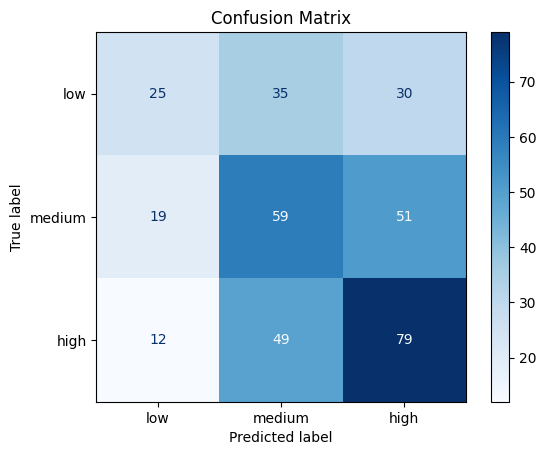

In [42]:
y_pred = best_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['low', 'medium', 'high'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low', 'medium', 'high'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()